# Exploratory Data Analysis of PNAS Data

## Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from dtw import dtw

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import plot_tree, export_graphviz

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

# type checking
from typing import Dict

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# evolutionary optimisation
import random
from thresholding import *

# statistical metrics
from scipy import stats
from scipy.fft import fft
from scipy.stats import kurtosis, skew, entropy, linregress, zscore, skew, kurtosis, shapiro
from scipy.spatial import distance

# other
from functools import partial

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Data Download

In [6]:
pnas_positives_df = pd.read_csv('./data/ingested/pnas/positive_pnas_timeseries_data.csv')

In [7]:
pnas_positives_df

,mins,sample,value,concentration,replicate
0,0.25,X1450.Copies.per.ul,16368.045,1450.000000,1
1,0.25,X1450.Copies.per.ul.2,9663.707,1450.000000,2
2,0.25,X1450.Copies.per.ul.3,11759.481,1450.000000,3
3,0.25,X725.Copies.per.ul,5199.029,725.000000,1
4,0.25,X725.Copies.per.ul.2,4488.901,725.000000,2
...,...,...,...,...,...
5545,37.50,X0.0042.Copies.per.ul.2,49467.254,0.004200,2
5546,37.50,X0.00042.Copies.per.ul,74514.695,0.000420,1
5547,37.50,X0.00042.Copies.per.ul.2,70103.310,0.000420,2
5548,37.50,X0.000042.Copies.per.ul,79176.984,0.000042,1


In [28]:
pnas_timeseries = pnas_positives_df.groupby('sample').apply(
    lambda x: x.sort_values('mins')['value'].values,
    include_groups=False
)

pnas_timeseries

sample
X0.000042.Copies.per.ul      [11114.071, 10868.606, 10710.472, 10686.687, 1...
X0.000042.Copies.per.ul.2    [6058.785, 5977.668, 5704.889, 5299.785, 4272....
X0.00042.Copies.per.ul       [5236.755, 5006.495, 4919.0, 5100.917, 5056.10...
X0.00042.Copies.per.ul.2     [11902.787, 11695.006, 11384.748, 11366.503, 1...
X0.0042.Copies.per.ul        [8725.541, 8426.771, 8180.936, 8048.045, 7858....
X0.0042.Copies.per.ul.2      [5506.397, 5238.062, 4636.822, 4322.072, 3784....
X0.042.Copies.per.ul         [8928.69, 8756.536, 7770.864, 7350.598, 6850.6...
X0.042.Copies.per.ul.2       [3000.009, 3026.136, 2936.945, 2726.463, 2246....
X0.42.Copies.per.ul          [7937.06, 7771.314, 7087.477, 6657.003, 6466.2...
X0.42.Copies.per.ul.2        [2690.903, 2646.816, 2598.927, 2370.879, 1758....
X0.725.Copies.per.ul         [6994.049, 7049.731, 7010.125, 6975.047, 7249....
X0.725.Copies.per.ul.2       [6707.234, 6579.456, 6382.487, 6175.433, 5716....
X0.725.Copies.per.ul.3       [3731.105, 3504.

## Visualising Curves

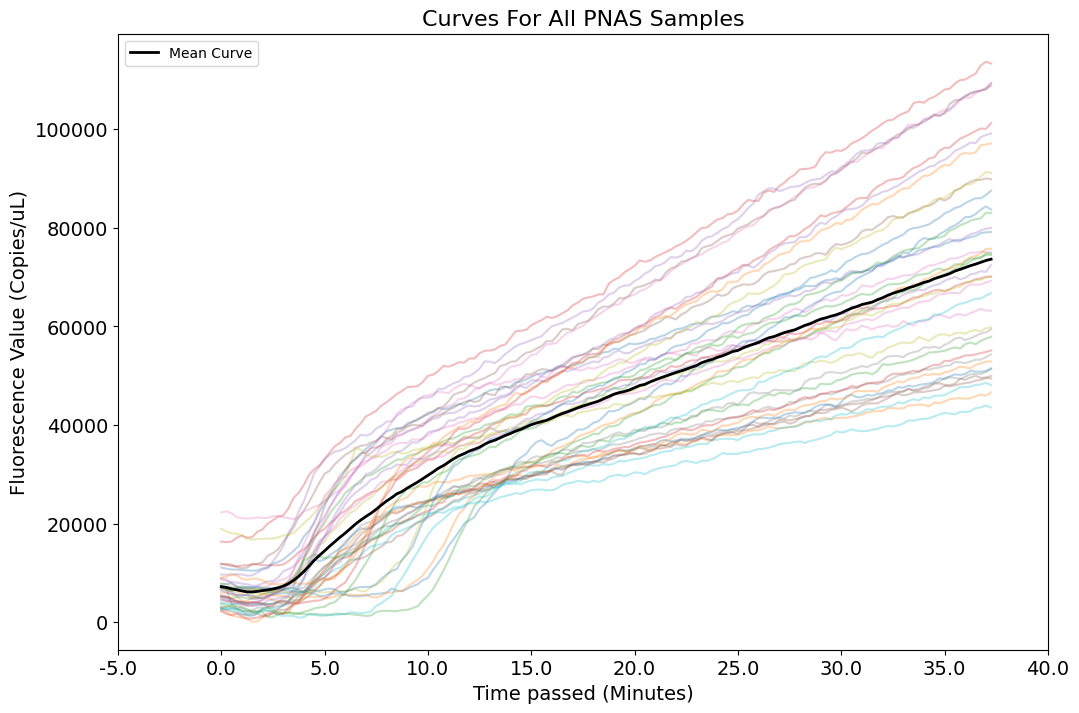

In [16]:
pnas_sequences_array = np.vstack(pnas_timeseries.values)

pnas_mean_curve = np.mean(pnas_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in pnas_timeseries:
    plt.plot(series, alpha=0.3)
plt.plot(pnas_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()

scale_factor =  15 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.title("Curves For All PNAS Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.ylabel('Fluorescence Value (Copies/uL)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Data scaling

**Normalisation**

In [26]:
pnas_timeseries = pnas_timeseries.apply(lambda x: (np.array(x) - np.min(x)) / (np.max(x) - np.min(x)) if len(x) > 1 else x)

**Standardisation**

In [29]:
#pnas_timeseries = pnas_timeseries.apply(lambda x: (np.array(x) - np.mean(x)) / np.std(x) if len(x) > 1 else x)

## Visualising the curves

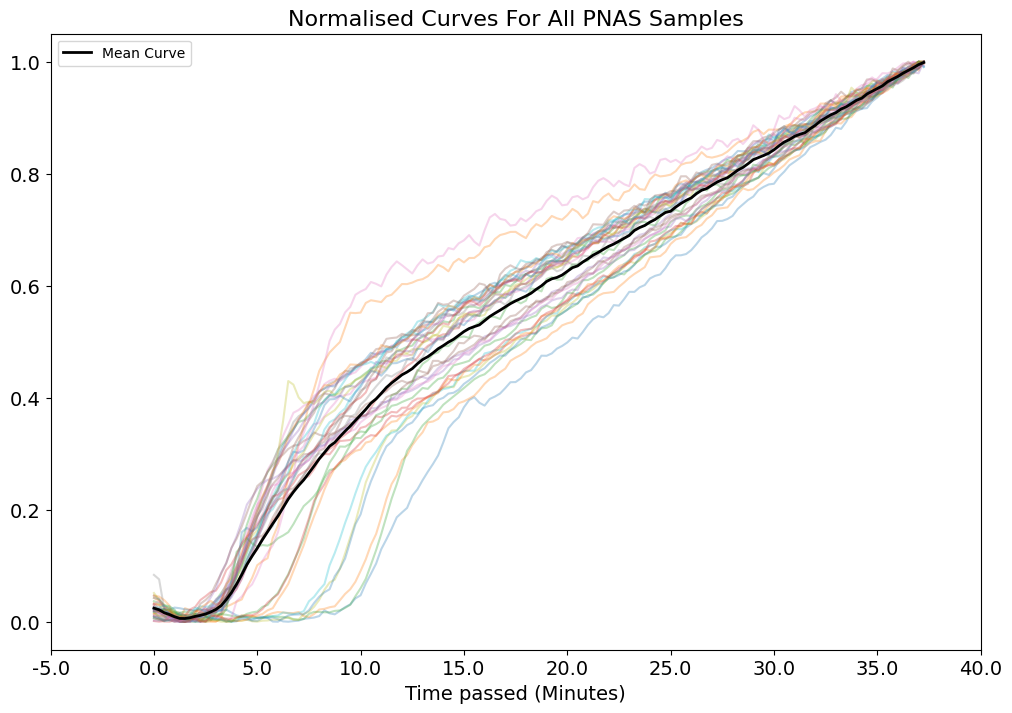

In [27]:
pnas_sequences_array = np.vstack(pnas_timeseries.values)

pnas_mean_curve = np.mean(pnas_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in pnas_timeseries:
    plt.plot(series, alpha=0.3)
plt.plot(pnas_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()

scale_factor =  15 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.title("Normalised Curves For All PNAS Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

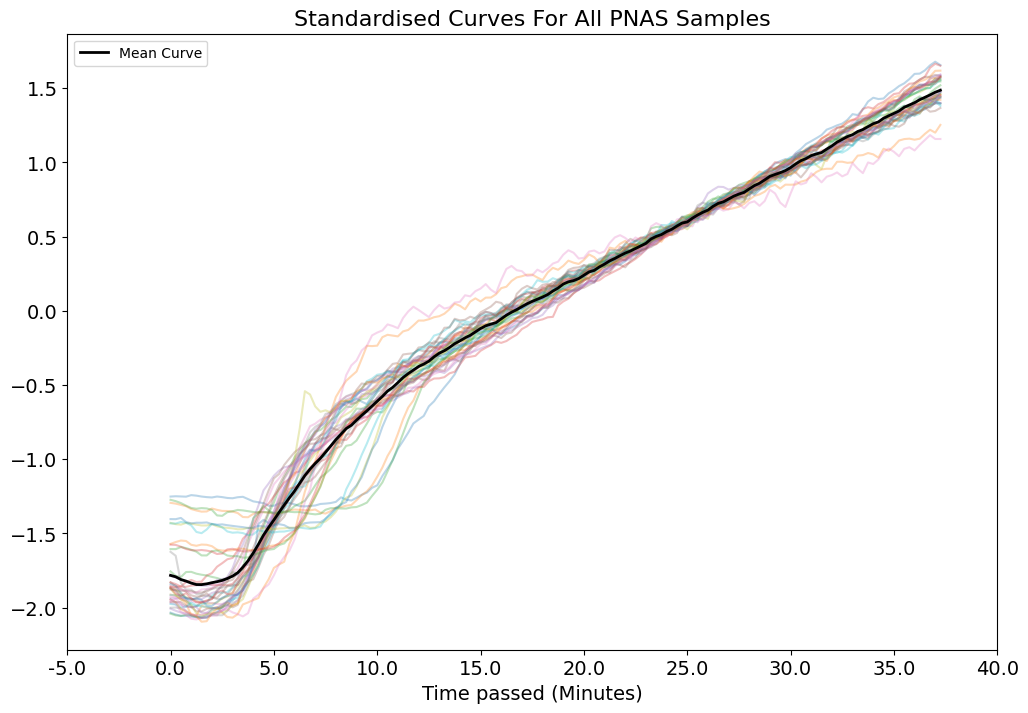

In [30]:
pnas_sequences_array = np.vstack(pnas_timeseries.values)

pnas_mean_curve = np.mean(pnas_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in pnas_timeseries:
    plt.plot(series, alpha=0.3)
plt.plot(pnas_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()

scale_factor =  15 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.title("Standardised Curves For All PNAS Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()